In [1]:
import sys
sys.path.append('/Users/sam/All-Program/App/ObjectDetection/')

import logging
logging.basicConfig(level=logging.DEBUG, filename="logfile.log", filemode="w",
                    format="%(asctime)-15s %(levelname)-8s %(message)s")

import numpy as np
from scipy import ndimage
from scipy import misc

import tensorflow as tf
from FasterRCNN.building_blocks import vgg, rpn, proposals, fastrcnn

import matplotlib.pyplot as plt
%matplotlib inline

img_path = '/Users/sam/All-Program/App-DataSet/ObjectDetection/images/3627527276_6fe8cd9bfe_z.jpg'
model_path = '/Users/sam/All-Program/App-DataSet/ObjectDetection/FasterRCNN/vgg16_weights.npz'

In [2]:
def vizualize(imageArray, title_arr, data_type, rows, columns, figsize=(40, 6)):
    fig1, axs = plt.subplots(rows,columns, figsize=figsize, facecolor='y', edgecolor='k')
    if columns>1:
        axs = axs.ravel()
    for no,image in enumerate(imageArray):
        axs[no].imshow(np.array(image.reshape(image.shape[0], image.shape[1]), dtype=data_type))

## Vizualize feature map

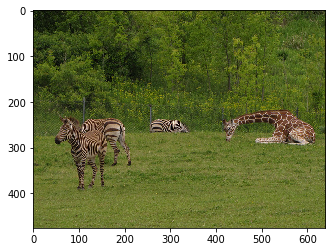

In [3]:
image = ndimage.imread(img_path, mode='RGB')
plt.imshow(np.array(image, dtype='uint8'))

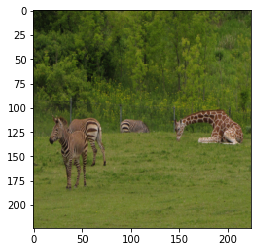

In [4]:
image = misc.imresize(image, [224,224])
plt.imshow(np.array(image, dtype='uint8'))

In [5]:
tf.reset_default_graph()

obj_vgg = vgg.vgg16(mode='test', model_path=model_path)
input_image, feature_map = obj_vgg.get_feature_map([224, 224, 3])

# RPN
obj_rpn = rpn.rpn(mode='train', feature_map=feature_map)
rpn_box_class_prob = obj_rpn.get_rpn_box_class_prob()
rpn_bbox = obj_rpn.get_rpn_bbox()

# PROPOSAL
proposals_ = tf.py_func(proposals.get_proposal_wrapper, ['test', rpn_box_class_prob, rpn_bbox], [tf.float32])
# proposals_
# FastRCNN
obj_roi_pool = fastrcnn.FastRCNN(feature_map, proposals_[0], image_shape=image.shape)
class_probs = obj_roi_pool.get_class_probs()

FastRCNN - Pooled Feature Map shape =  (?, 7, 7, 512)
FastRCNN - FC1 shape =  (?, 1024)
FastRCNN - FC2 shape =  (?, 1024)
FastRCNN - FC21 + Softmax shape =  (?, 4)
FastRCNN - FC21 + Box Reg shape =  (?, 16)


In [6]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    fmap = sess.run(feature_map, feed_dict={input_image:image.reshape(1, image.shape[0], image.shape[1], image.shape[2])})
    print (fmap.shape)

(1, 14, 14, 512)


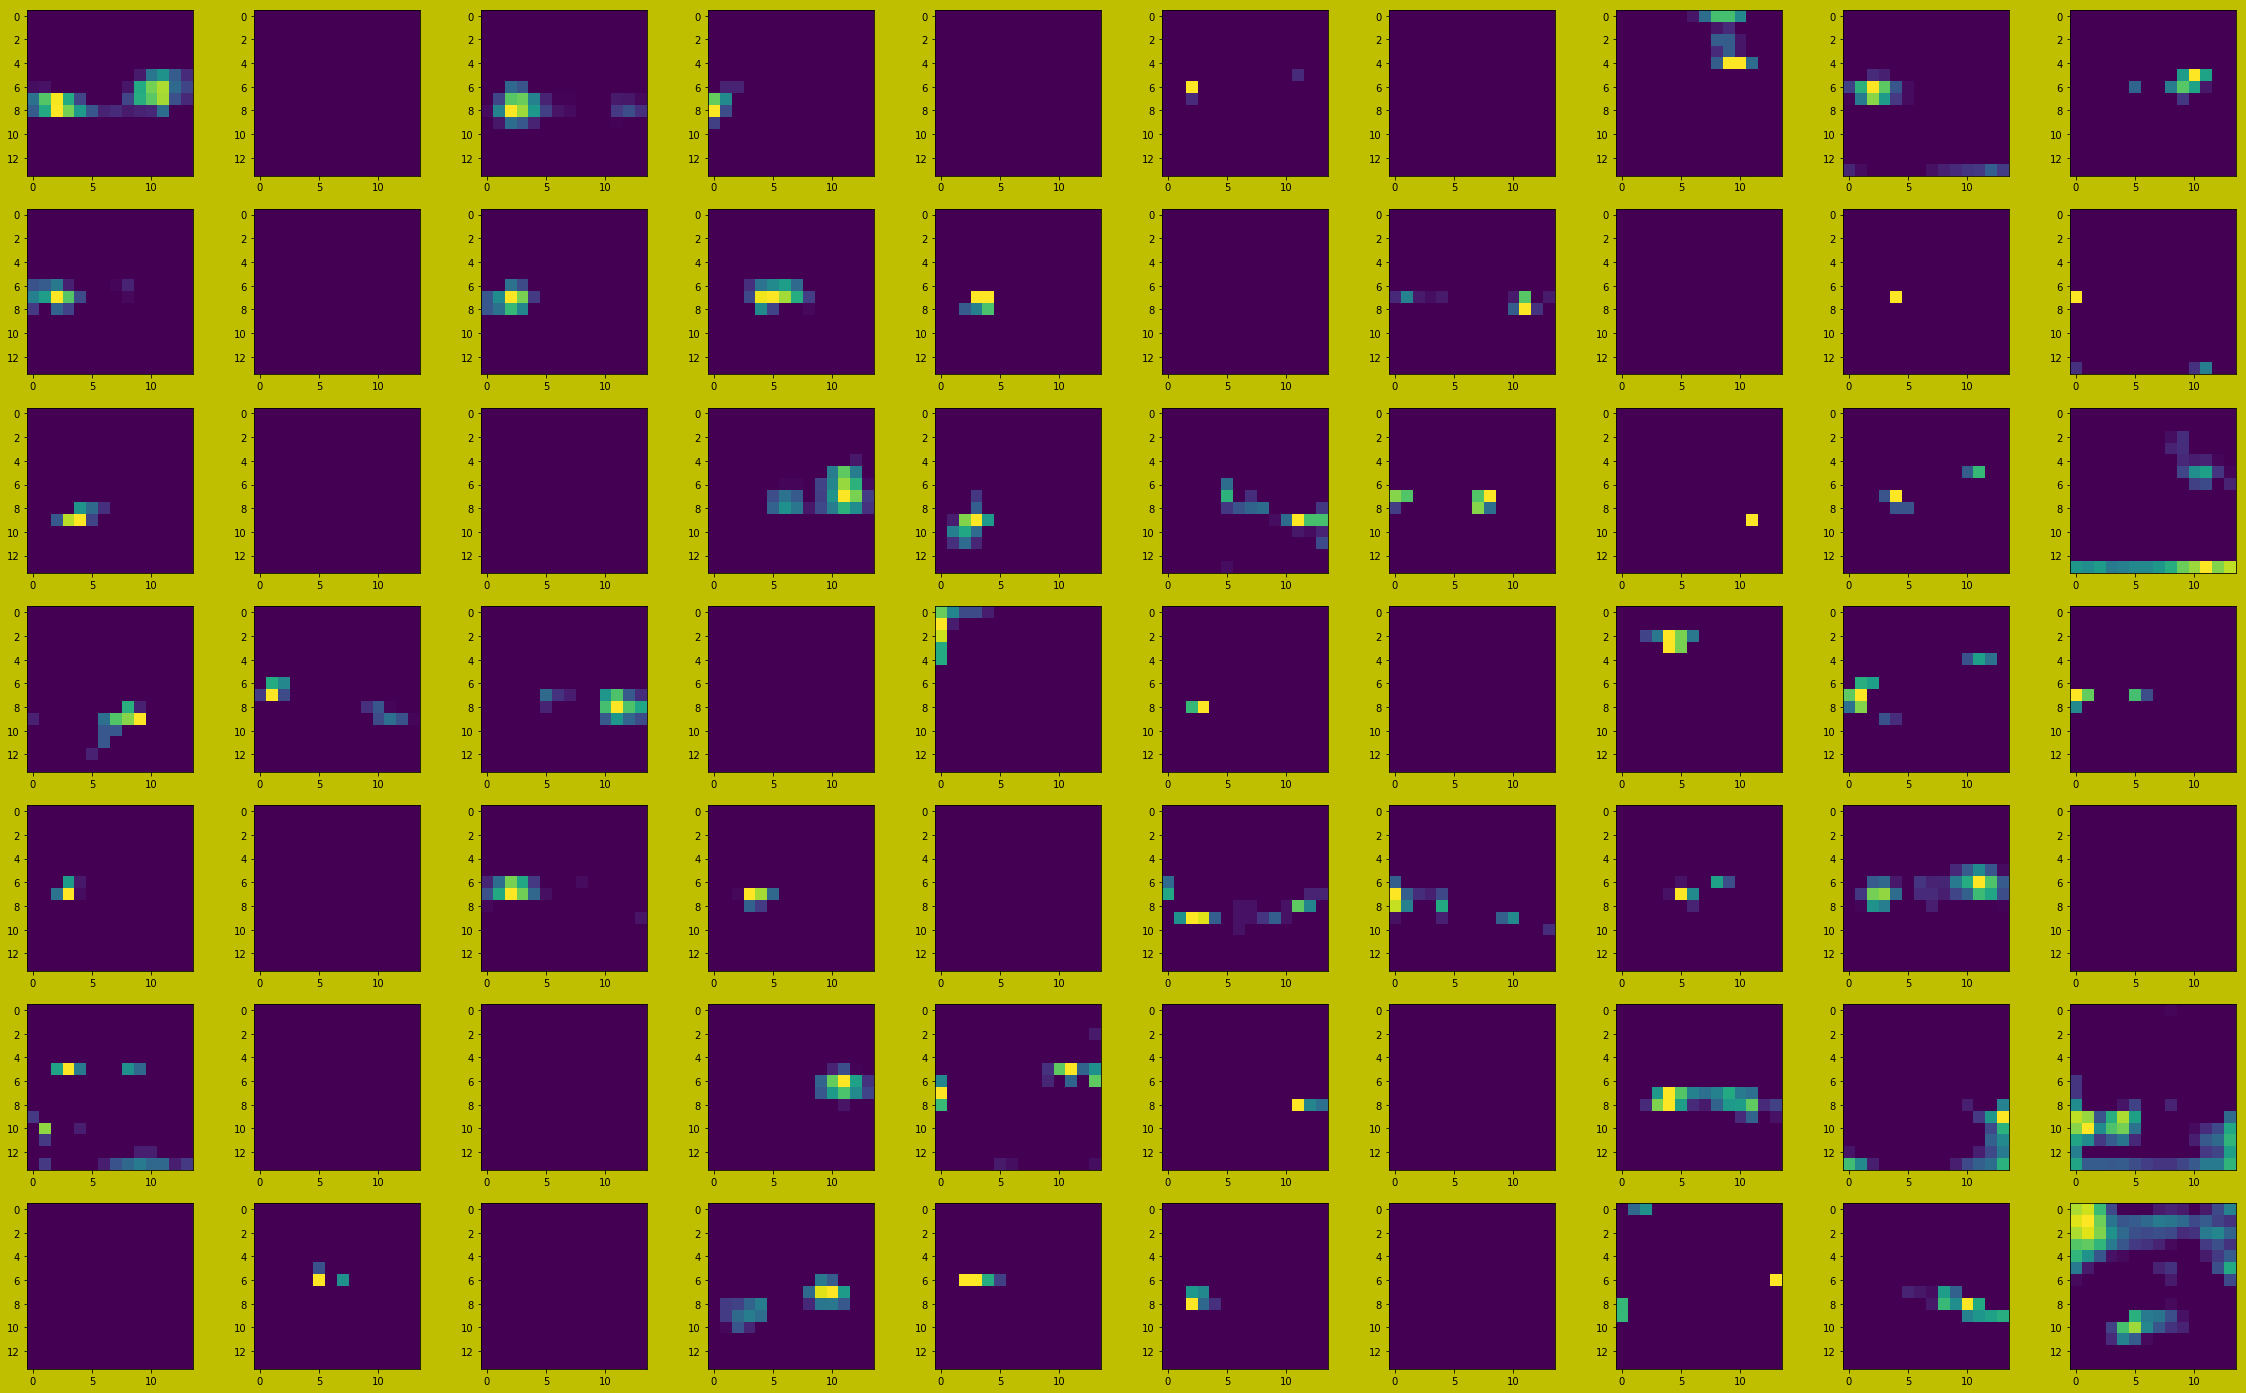

In [7]:
nrows = 7
ncols = 10
tot = nrows*ncols
from_ = 200
map_shape = [14, 14]
feature_maps = np.dsplit(fmap[:,:,:,from_:from_+tot].reshape(map_shape[0], map_shape[1], tot), tot)
vizualize(feature_maps, [], data_type='uint8', rows=nrows, columns=ncols, figsize=(40, 25))

## RPN

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    rpn_score, rpn_pred = sess.run([rpn_box_class_prob, rpn_bbox], feed_dict={input_image:image.reshape(1, image.shape[0], image.shape[1], image.shape[2])})
    print (rpn_score.shape, rpn_pred.shape)

(1, 14, 14, 18) (1, 14, 14, 36)


## PROPOSAL

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cls_prob_ = sess.run(class_probs, feed_dict={input_image:image.reshape(1, image.shape[0], image.shape[1], image.shape[2])})


................... build 2
rpn_bbox_cls_prob: (1, 14, 14, 18)
rpn_bbox: (1, 14, 14, 36)
scores: rpn_bbox_cls_prob reshaped: (1764, 1)
bbox_delta : rpn_bbox reshaped: (1764, 4)

anchors  (1764, 4)
proposals shape (corner pixel to center) (1764, 4)
clip_boxes self.boxes  (1764, 4)
filter_min_size self.boxes  (1764, 4)
Pre Non-Max suppression boxes:  (1764, 4)
Post non_max_suppression boxes  (1, 4)
proposals shape (after filter) (1, 4)


## ROI POOLING

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    p_sals = sess.run(proposals_, feed_dict={input_image:image.reshape(1, image.shape[0], image.shape[1], image.shape[2])})
#     print (p_sals[0].shape)

In [11]:
len(p_sals)

1

In [12]:
p_sals[0][:,0]

array([ 0.], dtype=float32)

In [13]:
p_sals[0]

array([[   0.        ,    0.        ,  100.20674896,   56.10328674]], dtype=float32)